In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# adjust pandas printing

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [3]:
# import data from pickle 

dfRaw = pd.read_pickle('./final_final.pkl')
df = dfRaw.copy()

In [4]:
# drop un-needed columns

df = df.drop(columns = ['URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)'
#                         ,'Neighborhood'
                        ,'Location'
                        ,'dt'
                        ,'censusTract'
                        ,'censusCounty' 
                        ,'censusState'
                       ,'joinKey'
                       ])

In [5]:
# drop illogicals 

df = df.dropna()
df = df[df['LOT SIZE'] < 125000] # one record has lot size of 165310200... illogical 
df = df[df['LOT SIZE'] > 1620] # one record has lot size of 165310200... illogical

In [6]:
# engineeer features 

# df['sqftPerBedroom'] = df['SQUARE FEET'] / df['BEDS']
# df.drop(columns=['SQUARE FEET', 'BEDS'], axis = 1, inplace=True)

In [7]:
# inspect dataframe
# set up scaler 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'yeo-johnson')

# set up X and Y
X = df.loc[:, df.columns != 'PRICE']

y = df['PRICE']

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=131)
# y_train = np.log(y_train) # perform log transformation

# train set 
scaling_columns = X.loc[ : , X.columns[~X.columns.str.startswith("Neigh")] ].columns
X_train[scaling_columns] = scaler.fit_transform(X_train[scaling_columns])
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
train_data = pd.concat([X_train, y_train], axis=1)

# test set
X_test[scaling_columns] = scaler.transform(X_test[scaling_columns]) # do not fit the scaler on testing data, only transform it from training instances 

# inspect data to make sure
print("total df size: " + str(len(df)))
print("total training size: " + str(len(X_train)))
print("total test size: " + str(len(X_test)))
df.head()

total df size: 1586
total training size: 1268
total test size: 318


,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,X,Y,Z,yearSold,Neighborhood_Arlington,Neighborhood_Aspinwall,Neighborhood_Bloomfield,Neighborhood_Central North Side,Neighborhood_Downtown Pgh,Neighborhood_E Pittsburgh,Neighborhood_East Allegheny,Neighborhood_East Liberty,Neighborhood_Edgewood,Neighborhood_Fox Chapel,Neighborhood_Friendship Park,Neighborhood_Garfield,Neighborhood_Greenfield,Neighborhood_Hazelwood,Neighborhood_Highland Park,Neighborhood_Hill District,Neighborhood_Homestead,Neighborhood_Homewood-Brushton,Neighborhood_Lawrenceville,Neighborhood_Lincoln Place,Neighborhood_Lincoln-Larimer,Neighborhood_Morningside,Neighborhood_Mt Oliver,Neighborhood_Munhall,Neighborhood_Murdoch Farms,Neighborhood_North of Forbes,Neighborhood_O'Hara,Neighborhood_Oakland,Neighborhood_Penn Hills,Neighborhood_Point Breeze,Neighborhood_Polish Hill,Neighborhood_Regent Square,Neighborhood_Reserve,Neighborhood_Ross Twp,Neighborhood_Schenley Farms,Neighborhood_Schenley Heights,Neighborhood_Shadyside,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg,sin_monthSold,PRICE,Crime Score,HS_Score,ES_MS_Score,age_Median,housing_OwnerOccupiedMedianValue,renting_MedianRentValue,inequality_GiniIndex,commute_pctLessThan34Mins,bachelors_pctSTEM,education_pctAdvancedDegree,income_pctBelow50K,income_pctAbove150K
1,5.0,2.0,3034.0,2178.0,1900.0,0.142107,-0.921593,0.361209,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.224647e-16,302500.0,25.490296,58.833333,79.666667,37.1,250800,981.0,0.4614,0.886846,0.086353,0.272128,0.423819,0.155023
3,2.0,1.5,1226.0,1742.0,1890.0,0.134636,-0.921550,0.364169,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.000000e+00,379900.0,17.730598,58.833333,70.000000,33.4,265700,1156.0,0.4399,0.864430,0.084000,0.288262,0.306991,0.190729
4,3.0,3.0,1519.0,2178.0,1910.0,0.142769,-0.924006,0.354725,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2.449294e-16,390000.0,15.909914,90.800000,79.666667,33.2,250000,1470.0,0.4843,0.903743,0.134723,0.295797,0.287625,0.275920
5,3.0,3.5,2460.0,2613.0,1920.0,0.157883,-0.915595,0.369809,21,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-5.000000e-01,612000.0,22.756471,90.800000,65.000000,29.8,348800,991.0,0.4274,0.858113,0.134409,0.308480,0.339822,0.136253
6,3.0,1.0,1557.0,2252.0,1906.0,0.160184,-0.901313,0.402463,22,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-5.000000e-01,299000.0,8.298895,82.866667,54.666667,39.5,190700,1009.0,0.4576,0.862815,0.127652,0.269265,0.414455,0.091480


In [8]:
df.describe()

,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,X,Y,Z,yearSold,Neighborhood_Arlington,Neighborhood_Aspinwall,Neighborhood_Bloomfield,Neighborhood_Central North Side,Neighborhood_Downtown Pgh,Neighborhood_E Pittsburgh,Neighborhood_East Allegheny,Neighborhood_East Liberty,Neighborhood_Edgewood,Neighborhood_Fox Chapel,Neighborhood_Friendship Park,Neighborhood_Garfield,Neighborhood_Greenfield,Neighborhood_Hazelwood,Neighborhood_Highland Park,Neighborhood_Hill District,Neighborhood_Homestead,Neighborhood_Homewood-Brushton,Neighborhood_Lawrenceville,Neighborhood_Lincoln Place,Neighborhood_Lincoln-Larimer,Neighborhood_Morningside,Neighborhood_Mt Oliver,Neighborhood_Munhall,Neighborhood_Murdoch Farms,Neighborhood_North of Forbes,Neighborhood_O'Hara,Neighborhood_Oakland,Neighborhood_Penn Hills,Neighborhood_Point Breeze,Neighborhood_Polish Hill,Neighborhood_Regent Square,Neighborhood_Reserve,Neighborhood_Ross Twp,Neighborhood_Schenley Farms,Neighborhood_Schenley Heights,Neighborhood_Shadyside,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg,sin_monthSold,PRICE,Crime Score,HS_Score,ES_MS_Score,age_Median,housing_OwnerOccupiedMedianValue,renting_MedianRentValue,inequality_GiniIndex,commute_pctLessThan34Mins,bachelors_pctSTEM,education_pctAdvancedDegree,income_pctBelow50K,income_pctAbove150K
count,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.0,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1.586000e+03,1.586000e+03,1586.000000,1586.000000,1586.000000,1586.00000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000
mean,3.528373,2.115700,1968.727617,4555.271753,1922.409836,0.163570,-0.909596,0.380529,21.185372,0.006936,0.018285,0.027743,0.000631,0.005044,0.001261,0.004414,0.031526,0.011980,0.000631,0.017024,0.023960,0.083228,0.014502,0.050441,0.009458,0.000631,0.010088,0.077554,0.000631,0.018285,0.040984,0.001892,0.003153,0.001892,0.003153,0.001261,0.021438,0.001892,0.053594,0.009458,0.056747,0.001892,0.0,0.004414,0.003783,0.046658,0.014502,0.049811,0.000631,0.003783,0.001261,0.155107,0.047919,0.025221,0.029634,0.003783,-1.188884e-01,3.847803e+05,15.123463,80.628478,60.345944,37.14029,230806.179067,1061.740858,0.473452,0.827804,0.084249,0.305651,0.428308,0.159645
std,1.108392,0.985868,968.662560,4768.873813,27.266480,0.023089,0.009771,0.021183,1.022615,0.083018,0.134022,0.164287,0.025110,0.070865,0.035500,0.066309,0.174789,0.108829,0.025110,0.129401,0.152972,0.276314,0.119585,0.218923,0.096821,0.025110,0.099964,0.267552,0.025110,0.134022,0.198315,0.043465,0.056077,0.043465,0.056077,0.035500,0.144884,0.043465,0.225286,0.096821,0.231431,0.043465,0.0,0.066309,0.061410,0.210972,0.119585,0.217623,0.025110,0.061410,0.035500,0.362121,0.213663,0.156844,0.169630,0.061410,6.742598e-01,2.993237e+05,11.310968,12.347107,8.301735,6.75581,126023.205200,210.044451,0.062914,0.064708,0.037871,0.151785,0.157112,0.120071
min,1.000000,1.000000,672.000000,1624.000000,1620.000000,0.102555,-0.927487,0.335912,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [9]:
# function that computes the error metrics 

def computeMetricsForRegression(model_name, model_name_string,test_type, y_type): 
    
    RMSE = int(np.sqrt(mean_squared_error(y_type,model_name)))
    MAE = int(mean_absolute_error(y_type,model_name))
    R2 = r2_score(y_type, model_name)
    
    print('\n',model_name_string,' results ', test_type, '\n')
    print("RMSE: ", f"{RMSE:,}")
    print("MAE:  ", f"{MAE:,}")
    print("R^2:  ", f"{R2:,.2f}")
    print()
    
    # source: https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/
    fig, ax = plt.subplots()
    ax.scatter(model_name, y_type, edgecolors=(0, 0, 1))
#     ax.plot([y_type.min(), y_type.max()], [y_type.min(), y_type.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.ticklabel_format(style='plain')
    plt.show()


In [10]:
# # inspect skew for feature transformation
# # source: https://github.com/rachittoshniwal/machineLearning/blob/master/power%20transformer.ipynb

# def plots(df, var, t):
#     plt.figure(figsize=(13,5))
#     plt.subplot(121)
#     sns.kdeplot(df[var])
#     plt.title('before ' + str(t).split('(')[0])
    
#     plt.subplot(122)
#     p1 = t.fit_transform(df[[var]]).flatten()
#     sns.kdeplot(p1)
#     plt.title('after ' + str(t).split('(')[0])
    

# for col in X_train.columns:
#     plots(X, col, PowerTransformer())

In [11]:
# AUTO ML 

from autogluon.tabular import TabularPredictor

label = 'PRICE'  # name of target variable to predict 
save_path = 'AutoGluonModels/'  # where to store trained models

In [12]:
# train auto ml model
# source: https://www.analyticsvidhya.com/blog/2021/10/beginners-guide-to-automl-with-an-easy-autogluon-example/#h2_10
# source: https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-indepth.html

predictor = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(
    train_data = train_data,
    num_gpus=1,  # Grant 1 gpu for the entire Tabular Predictor
    time_limit=800, 
    presets='best_quality',
)

No path specified. Models will be saved in: "AutogluonModels\ag-20221214_234817\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 800s
AutoGluon will save models to "AutogluonModels\ag-20221214_234817\"
AutoGluon Version:  0.6.0
Python Version:     3.9.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    1268
Train Data Columns: 69
Label Column: PRICE
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3150000.0, 6000.0, 381566.74369, 299548.80781)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature 

Fitting model: XGBoost_BAG_L2 ... Training model for up to 227.83s of the 227.79s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-89262.9876	 = Validation score   (-mean_absolute_error)
	33.72s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 188.95s of the 188.91s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	Time limit exceeded... Skipping NeuralNetTorch_BAG_L2.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 180.87s of the 180.83s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-91902.9859	 = Validation score   (-mean_absolute_error)
	119.77s	 = Training   runtime
	0.06s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 52.95s of remai

In [13]:
# look at leaderboard 

predictor.leaderboard(train_data, silent = True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-0.007289,-100992.506958,0.079009,0.081208,0.014999,0.079009,0.081208,0.014999,1,True,2
1,LightGBMLarge_BAG_L1,-20299.924330,-89172.474770,0.404001,0.097007,145.528983,0.404001,0.097007,145.528983,1,True,10
2,ExtraTreesMSE_BAG_L1,-31708.397669,-85906.788141,0.341682,0.168984,0.596017,0.341682,0.168984,0.596017,1,True,7
3,RandomForestMSE_BAG_L1,-32505.548551,-88127.407676,0.331591,0.191004,0.714000,0.331591,0.191004,0.714000,1,True,5
4,XGBoost_BAG_L1,-40178.652921,-85982.533311,0.561998,0.074003,33.022391,0.561998,0.074003,33.022391,1,True,9
5,ExtraTreesMSE_BAG_L2,-42719.509726,-85464.228149,3.391785,1.353254,360.918140,0.338007,0.182002,0.601001,2,True,16
6,RandomForestMSE_BAG_L2,-43003.156720,-87247.874994,3.385786,1.451253,361.485189,0.332007,0.280001,1.168050,2,True,14
7,XGBoost_BAG_L2,-43793.811178,-89262.987622,3.342772,1.247250,394.038609,0.288993,0.075998,33.721470,2,True,18
8,LightGBMLarge_BAG_L2,-45826.988075,-91902.985906,3.336777,1.229243,480.091768,0.282998,0.057991,119.774629,2,True,19
9,WeightedEnsemble_L3,-46737.861347,-83065.842550,4.106779,1.790244,476.612631,0.008001,0.000000,0.221656,3,True,20


In [14]:
# inspect results 

results = predictor.fit_summary()
results

*** Summary of fit() ***
Estimated performance of each model:
                     model      score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -81686.442714       0.684034  214.343156                0.000000           0.293000            2       True         11
1      WeightedEnsemble_L3  -83065.842550       1.790244  476.612631                0.000000           0.221656            3       True         20
2          CatBoost_BAG_L2  -84386.280645       1.215253  407.925881                0.044001          47.608742            2       True         15
3        LightGBMXT_BAG_L2  -84496.885302       1.207251  381.730276                0.036000          21.413137            2       True         12
4     ExtraTreesMSE_BAG_L2  -85464.228149       1.353254  360.918140                0.182002           0.601001            2       True         16
5        LightGBMXT_BAG_L1  -85467.494769       0.040000

C:\Users\CT\miniconda3\envs\automl\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'Ligh

In [15]:
# feature importance

importance = predictor.feature_importance(feature_stage='original', data=pd.concat([X_test, y_test],axis=1))

These features in provided data are not utilized by the predictor and will be ignored: ['Neighborhood_Homestead', 'Neighborhood_Ross Twp', 'Neighborhood_South-Other Area']
Computing feature importance via permutation shuffling for 66 features using 318 rows with 5 shuffle sets...
	455.83s	= Expected runtime (91.17s per shuffle set)
	30.75s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [16]:
# view importance 

importance

,importance,stddev,p_value,n,p99_high,p99_low
BATHS,39829.075764,3857.391225,0.000010,5,47771.497610,31886.653918
SQUARE FEET,26056.011393,2459.341411,0.000009,5,31119.829350,20992.193435
housing_OwnerOccupiedMedianValue,15386.350447,2491.969416,0.000080,5,20517.349917,10255.350977
yearSold,4169.970464,473.025623,0.000020,5,5143.936760,3196.004169
LOT SIZE,3517.245197,1569.420518,0.003715,5,6748.703735,285.786659
YEAR BUILT,3220.011136,1142.442801,0.001620,5,5572.316653,867.705620
income_pctAbove150K,1525.290065,374.346102,0.000403,5,2296.073864,754.506266
commute_pctLessThan34Mins,1233.726010,697.693053,0.008381,5,2670.285650,-202.833630
education_pctAdvancedDegree,1111.898135,768.443067,0.015905,5,2694.133032,-470.336761
Crime Score,1053.807798,755.312520,0.017768,5,2609.006716,-501.391120


In [17]:
# make predictions on the test data set using the best model from autogluon

pred_test_autogluon = predictor.predict(X_test)
# pred_test_autogluon = np.exp(pred_test_autogluon)


 Augogluon Regression  results  Test 

RMSE:  127,356
MAE:   83,579
R^2:   0.82



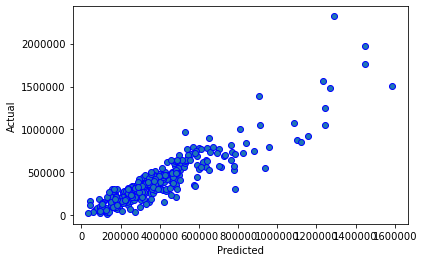

In [18]:
# get some summary statistics for testing data

computeMetricsForRegression(pred_test_autogluon, 'Augogluon Regression','Test', y_test)

In [19]:
pred_test_autogluon

432     289914.062500
422     347414.218750
264     421179.312500
1296    158795.718750
197     174251.875000
            ...      
14      307771.500000
1236    504984.687500
755     184060.140625
1249    286723.625000
103     427949.843750
Name: PRICE, Length: 318, dtype: float32

In [20]:
y_test

432     333000.0
422     340000.0
264     290000.0
1296    102000.0
197     193000.0
          ...   
14      345000.0
1236    410000.0
755     123000.0
1249    330000.0
103     468975.0
Name: PRICE, Length: 318, dtype: float64


 Augogluon Regression  results  Test 

RMSE:  83,071
MAE:   59,941
R^2:   0.32



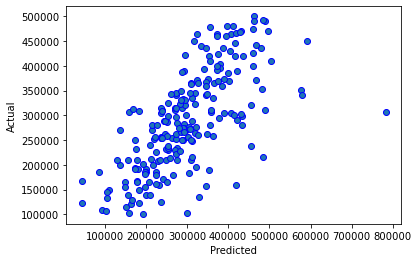

In [21]:
# limit results to feasible range

yHat = pd.DataFrame(pred_test_autogluon)
yHat.rename(columns={'PRICE':'yHat'}, inplace = True)

yActual = pd.DataFrame(y_test)
yActual.rename(columns={'PRICE':'yActual'}, inplace = True)

yHat.reset_index(inplace=True, drop=True)
yActual.reset_index(inplace=True, drop=True)

testResults = pd.concat([yHat, yActual], axis=1)

testResultsLimited = testResults.loc[(testResults['yActual'] > 100000) & (testResults['yActual'] < 500000)]

computeMetricsForRegression(testResultsLimited['yHat'], 'Augogluon Regression','Test', testResultsLimited['yActual'])